In [1]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report
from sktime.transformations.panel.rocket import MiniRocketMultivariate as minirocket
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV as LRCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [2]:
# get relative indices
# manually entered via looking at
#https://raw.githubusercontent.com/google/mediapipe/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules
#/face_geometry/data/canonical_face_model_uv_visualization.png

lower = [76, 77, 90, 180, 85, 16, 315, 404, 320, 307]

upper = [184, 74, 73, 72, 11, 302, 303, 304, 408, 306]

u2 = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409]
l2 = [291, 375, 321, 405, 314, 17, 84, 181, 91, 146]

u3 = [57, 186, 92, 165, 167, 164, 393, 391, 322, 410]
l3 = [287, 273, 335, 406, 313, 18, 83, 182, 106, 43]

combo_indices = lower + upper + u2 + l2 + u3 + l3

In [3]:
len(combo_indices)

60

In [4]:
opath = "/Users/nraman/Documents/thesis_videos/"
# make sure to get 
subfolders = [i for i in os.listdir(opath) if ".mp4" not in i and ".DS_Store" not in i and ".MOV" not in i and ":" in i]
def find_pointfolder(subfolder, path = "/Users/nraman/Documents/thesis_videos/"):
    cur_path = f"{path}{subfolder}"
    # get names of files within the subfolder
    subfiles = os.listdir(f"{path}{subfolder}")
    nps = [i for i in subfiles if ".npy" in i]
    
    if(len(nps) == 1):
        array = np.load(f"{cur_path}/{nps[0]}")
        array = array[:, combo_indices]
        return(array.reshape(array.shape[0], len(combo_indices)*2))

In [5]:
ground_folders = [i for i in subfolders if "ground" in i]
speak_folders = [i for i in subfolders if "ground" not in i]
bad_ones = []

ground_data = []
speak_data = []

for s in speak_folders:
    data = find_pointfolder(s)
    #if(len(data) < 40):
    if(type(data) == np.ndarray):
        speak_data.append(data)
    else:
        bad_ones.append(s)

s_lengths = [s.shape[0] for s in speak_data]
g_lengths = []

for g in ground_folders:
    ar_init = find_pointfolder(g)
#     num_instances = ar_init.shape[0]
#     g_lengths.append(num_instances)
#     choice = np.random.randint(15, 30)
    
#     if(num_instances > 700):
#         splits = 2
#     else:
#         splits = 1
    
    #ground_data.extend(np.array_split(ar_init, splits))
    if(type(ar_init) == np.ndarray):
        ground_data.append(ar_init)
    else:
        bad_ones.append(g)
        
s_lengths = [s.shape[0] for s in speak_data]
g_lengths = [s.shape[0] for s in ground_data]
maxlen = np.max(s_lengths + g_lengths)

In [6]:
# each input is list of arrays (each 2d, of dimension #timepoints x #points*2)--ground corresponds to no speech
# get dataframe of dimension #samples x #features
def timeseries_df(groundlist, speaklist, num_features = len(combo_indices)*2, const = 0, pd_mode = True):
    sz = len(groundlist) + len(speaklist)
    numspeak = len(speaklist)
    
    if(pd_mode == True):
        df = pd.DataFrame(np.zeros([sz, num_features])).astype(object)
    else:
        df = np.zeros((sz, num_features, maxlen))
    
    for j in range(int(sz)):
        for a in range(len(combo_indices)*2):
            if(j < numspeak):
                cur = speaklist[j][:, a]
            elif (j >= numspeak):
                it = j - numspeak
                cur = groundlist[it][:, a]
            
            if(pd_mode == True):
                df.iloc[j, a] = np.pad(cur, (0, maxlen - len(cur)), constant_values = (const))
            else:
                df[a, j] = np.pad(cur, (0, maxlen - len(cur)), constant_values = (const))
    
    true = np.concatenate([np.ones(numspeak), np.zeros(sz - numspeak)])
    
    return df, true

In [29]:
alldata, alltrue = timeseries_df(ground_data, speak_data)

In [34]:
rocket = minirocket(num_kernels = 10000, n_jobs = -1)

In [35]:
accuracies = []

for i in tqdm(range(50)):
    X_train, X_test, y_train, y_test = train_test_split(alldata, alltrue, test_size=50, shuffle = True)
    rocket.fit(X_train)
    X_train_transform = rocket.transform(X_train)

    model = LDA(priors = [0.4, 0.6])
    model.fit(X_train_transform, y_train)
    
    accuracies.append(model.score(rocket.transform(X_test), y_test))


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]


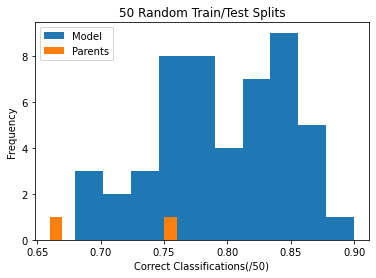

In [36]:
plt.hist(np.array(accuracies), label = "Model")
plt.hist([33/50, 38/50], label = "Parents")
plt.xlabel("Correct Classifications(/50)")
plt.ylabel("Frequency")
plt.title("50 Random Train/Test Splits")
plt.legend()
plt.show()

In [11]:
kf = KFold(n_splits=8, shuffle = True)
kf.get_n_splits(X = alldata, y = alltrue)

#adjustable priors!
prior_non = 0.5
prob_threshold = 0.5

preds = []
actual = []

for train_index, test_index in tqdm(kf.split(alldata, alltrue)):
    X_train, X_test = alldata.iloc[train_index,:], alldata.iloc[test_index,:]
    y_train, y_test = alltrue[train_index], alltrue[test_index]
    
    rocket.fit(X_train)
    X_train_transform = rocket.transform(X_train)
    
    scaler = StandardScaler().fit(X_train_transform)
    
    #ld = LDA()
    X_train_transform = scaler.transform(X_train_transform)
    
    model = LDA(priors = [prior_non, 1 - prior_non])#GaussianNB(priors = [0.4, 0.6])#LRCV(max_iter = 1000, class_weight = {0:1, 1:2})#SVC(kernel='rbf', probability=True)
    
    model.fit(X_train_transform, y_train) # 
    
    probabilities = model.predict_proba(scaler.transform(rocket.transform(X_test)))
    predictions = np.ones(len(y_test))
    
    confidents = np.where(np.max(probabilities, axis = 1) > prob_threshold)
    unconfidents = [i for i in np.arange(len(y_test)) if i not in confidents[0]]
    #pred_values = model.predict(scaler.transform(rocket.transform(X_test)))
    predictions[confidents] = np.argmax(probabilities[confidents], axis = 1)
    #predictions[unconfidents] = np.random.choice([0, 1])
    
    
    preds.append([int(i) for i in predictions[confidents]])
    actual.append([int(i) for i in y_test[confidents]])
    print(metrics.confusion_matrix(y_test[confidents], predictions[confidents]))
    print(model.score(scaler.transform(rocket.transform(X_test)),y_test))
    
    

1it [00:01,  1.61s/it]

[[27  7]
 [ 4 20]]
0.8103448275862069


2it [00:03,  1.60s/it]

[[30  4]
 [ 7 17]]
0.8103448275862069


3it [00:04,  1.59s/it]

[[32  2]
 [10 14]]
0.7931034482758621


4it [00:06,  1.60s/it]

[[30  4]
 [ 7 17]]
0.8103448275862069


5it [00:07,  1.59s/it]

[[28  6]
 [ 7 17]]
0.7758620689655172


6it [00:09,  1.59s/it]

[[30  4]
 [ 4 20]]
0.8620689655172413


7it [00:11,  1.58s/it]

[[29  5]
 [ 7 17]]
0.7931034482758621


8it [00:12,  1.59s/it]

[[28  6]
 [ 7 16]]
0.7719298245614035


In [12]:
allpreds = np.concatenate(preds)
allactual = np.concatenate(actual)

print(classification_report(allactual, allpreds, target_names=["Non-Speech", "Speech"]))

              precision    recall  f1-score   support

  Non-Speech       0.82      0.86      0.84       272
      Speech       0.78      0.72      0.75       191

    accuracy                           0.80       463
   macro avg       0.80      0.79      0.79       463
weighted avg       0.80      0.80      0.80       463



In [13]:
c = metrics.confusion_matrix(allactual, allpreds)
data_size = len(ground_data+speak_data)
print("Confusion Matrix: " + str(c))
print("False rejection rate: " + str(c[1, 0]/data_size))
print("Unsure %: " + str(1 - (len(allactual) / data_size)))

Confusion Matrix: [[234  38]
 [ 53 138]]
False rejection rate: 0.11447084233261338
Unsure %: 0.0


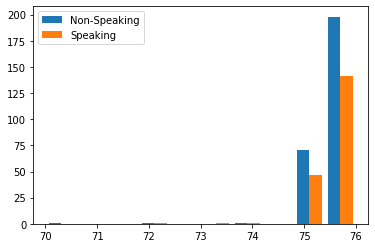

In [14]:
a = [g.shape[0] for g in ground_data]
b = [s.shape[0] for s in speak_data]

plt.hist([a, b], label = ["Non-Speaking", "Speaking"])
plt.legend()
plt.show()

What's the ideal probability threshold???

In [15]:
testfolders = [i for i in os.listdir("/Users/nraman/Documents/extra_videos/") if ".mp4" not in i 
               and ".DS_Store" not in i and ".MOV" not in i]

In [16]:
test_data = []

for s in testfolders:
    data = find_pointfolder(s, path = "/Users/nraman/Documents/extra_videos/")
    #if(len(data) < 40):
    if(type(data) == np.ndarray):
        test_data.append(data)


In [17]:
df = pd.DataFrame(np.zeros([len(test_data), 120])).astype(object)

In [18]:
old = np.array([1, 2, 3])
[i for i in np.array([0, 1, 2]) if i in old]

[1, 2]

In [19]:
len(ground_data)

272